## Convolution - Recurrent Model

This notebook adds a 1D convolution layer to the model. This version has a train/test split by subject.

In [19]:
import numpy as np
import pandas as pd
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, LSTM, Activation, Dense, Dropout, GRU,Conv1D,MaxPooling1D
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import ParameterSampler, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import itertools

In [4]:
df = pd.read_pickle('./thigh_clean.pkl')

In [5]:
df.head()

,attr_time_gyr,attr_x_gyr,attr_y_gyr,attr_z_gyr,attr_time_acc,attr_x_acc,attr_y_acc,attr_z_acc,activity,label,subject,sample_num
800,1435996984038,-0.786994,-0.328964,0.244081,1435996984038,0.469264,4.292205,1.912369,climbingdown,0,1,8
801,1435996984056,-0.539593,-0.340265,0.329907,1435996984056,0.769736,5.878364,2.906561,climbingdown,0,1,8
802,1435996984076,-0.334953,-0.454802,0.377860,1435996984076,1.098939,7.167043,3.312977,climbingdown,0,1,8
803,1435996984099,-0.086331,-0.496036,0.339070,1435996984099,1.409586,6.937798,4.225766,climbingdown,0,1,8
804,1435996984118,0.157099,-0.525052,0.350982,1435996984118,1.442507,6.427235,5.054759,climbingdown,0,1,8


In [6]:
df.subject.value_counts(1)

5     0.108505
8     0.106739
3     0.105781
9     0.105125
6     0.104066
10    0.103460
2     0.103360
1     0.098416
4     0.084140
7     0.080408
Name: subject, dtype: float64

In [7]:
df.activity.value_counts(1)

sitting         0.160513
standing        0.159554
walking         0.158697
lying           0.157284
climbingup      0.125303
running         0.119552
climbingdown    0.106638
jumping         0.012460
Name: activity, dtype: float64

In [8]:
# train/test split 
# subjects 1 to 7 are in train, subjects 8 to 10 are in test
columns =['attr_x_gyr','attr_y_gyr','attr_z_gyr','attr_x_acc','attr_y_acc','attr_z_acc']
train_mask = df.subject <= 7
test_mask = df.subject >= 8
X_train = df[columns][train_mask]
X_test = df[columns][test_mask]

In [9]:
# Create y
y_train=df[train_mask].label.groupby(df.sample_num).mean()
y_test=df[test_mask].label.groupby(df.sample_num).mean()

In [10]:
y_train.shape

(13573,)

In [11]:
y_test.shape

(6251,)

In [12]:
y_train = to_categorical(y_train, 8)
y_test = to_categorical(y_test, 8)

In [13]:
X_train.shape

(1357300, 6)

In [14]:
X_test.shape

(625100, 6)

In [15]:
# from https://stackoverflow.com/questions/53870113/using-standardscaler-on-3d-data
sc = StandardScaler()
# num_instances, num_time_steps, num_features = X_train.shape
# X_train = np.reshape(X_train, newshape=(-1, num_features))
X_train = sc.fit_transform(X_train)

# X_train = np.reshape(X_train, newshape=(num_instances, num_time_steps, num_features))

# num_instances, num_time_steps, num_features = X_test.shape
# X_test = np.reshape(X_test, newshape=(-1, num_features))
X_test = sc.transform(X_test)
# X_test = np.reshape(X_test, newshape=(num_instances, num_time_steps, num_features))

In [16]:
X_train = np.array(X_train).reshape((-1,100,6))  # reshape into a series of 100x6 arrays - windowsize x num_features
X_test = np.array(X_test).reshape((-1,100,6))

In [17]:
pkl_filename = "scaler_fit_to_train.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(sc, file)

In [17]:
y_train.shape

(13573, 8)

In [20]:
# specify the model
model = Sequential()

# create  model layers
model.add(Conv1D(filters=50, kernel_size=3,input_shape=(X_train.shape[1], 6),activation='relu'))
model.add(MaxPooling1D(pool_size=4,padding='valid'))
model.add(BatchNormalization())
model.add(Conv1D(filters=50, kernel_size=3,activation='relu'))
model.add(MaxPooling1D(pool_size=2,padding='valid'))
model.add(BatchNormalization())
    # adding a dropout layer for the regularization and avoiding over fitting
    # flattening the output in order to apply the fully connected layer
# model.add(Flatten())
model.add(GRU(
    units=64,
#     input_shape=(X.shape[1],6), 
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
#     recurrent_initializer='zeros', 
#      bias_initializer='zeros', 
    return_sequences=True,  # because the next layer is also LSTM
    dropout=0.0, #0.303
    recurrent_dropout=0.0, #0.458 
    ))   
model.add(GRU(
    units=64,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
#     recurrent_initializer=Constant(value=0.1),
    return_sequences=False,  # because the next layer is dense 
#     unit_forget_bias=True,
#     kernel_regularizer=None,
#     recurrent_regularizer='l2',
#     dropout=0.2, # 0.196
    recurrent_dropout=0.2  # 0.073
    ))
# model.add(Dense(16, kernel_initializer='uniform', activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(8, kernel_initializer='uniform',activation='softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
model.compile(loss='categorical_crossentropy', 
             optimizer=Adam(lr=0.001), 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 98, 50)            950       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 50)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 50)            200       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 22, 50)            7550      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 11, 50)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 50)            200       
_________________________________________________________________
gru_1 (GRU)                  (None, 11, 64)            22080     
__________

In [22]:
result = model.fit(X_train, y_train, epochs=5, batch_size=50, 
                   validation_data=(X_test,y_test), #callbacks=[early_stop]) #, model_saver]
                  )

Instructions for updating:
Use tf.cast instead.
Train on 13573 samples, validate on 6251 samples
Epoch 1/5
13573/13573 [==============================] - 24s 2ms/step - loss: 0.6751 - acc: 0.7555 - val_loss: 0.9847 - val_acc: 0.6423
Epoch 2/5
13573/13573 [==============================] - 19s 1ms/step - loss: 0.2550 - acc: 0.9075 - val_loss: 1.1691 - val_acc: 0.6604
Epoch 3/5
13573/13573 [==============================] - 20s 1ms/step - loss: 0.1980 - acc: 0.9248 - val_loss: 1.2520 - val_acc: 0.6602
Epoch 4/5
13573/13573 [==============================] - 17s 1ms/step - loss: 0.1698 - acc: 0.9353 - val_loss: 1.3295 - val_acc: 0.6727
Epoch 5/5
13573/13573 [==============================] - 17s 1ms/step - loss: 0.1384 - acc: 0.9481 - val_loss: 1.3386 - val_acc: 0.6863


In [24]:
pkl_filename = "model_conv_sub.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(model, file)


In [71]:
# get accuracy measures per class
# source: https://stackoverflow.com/questions/45930750/how-to-output-per-class-accuracy-in-keras
Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(X_test)
print(classification_report(Y_test, y_pred, 
                            target_names=["climbingdown","climbingup","jumping","lying","running","sitting","standing","walking"]))

              precision    recall  f1-score   support

climbingdown       0.32      0.75      0.44       460
  climbingup       0.72      0.50      0.59       719
     jumping       0.98      0.41      0.58       100
       lying       0.71      0.97      0.82       633
     running       0.57      0.62      0.59       691
     sitting       0.78      0.58      0.67       647
    standing       0.81      0.67      0.73       648
     walking       0.53      0.21      0.31       639

    accuracy                           0.60      4537
   macro avg       0.68      0.59      0.59      4537
weighted avg       0.65      0.60      0.60      4537



In [72]:
# source: https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    
    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout();

<Figure size 432x288 with 0 Axes>

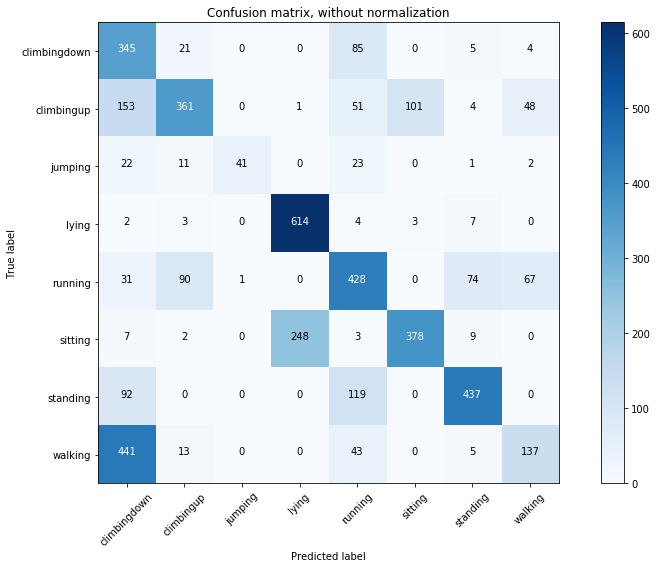

In [73]:
np.set_printoptions(precision=2)
cm = confusion_matrix(Y_test, 
                      y_pred, 
                      )
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, 
                      classes=["climbingdown","climbingup","jumping","lying","running","sitting","standing","walking"],
                      title='Confusion matrix, without normalization');


In [ ]:
score, acc = model.evaluate(X_test, y_test, verbose=1)
print("Score: {}; acc: {}".format(score, acc))

## Validate on held-out data for remaining 5 subjects